In [5]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='../data', train=True,
                                   download=False, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

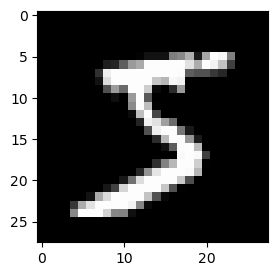

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers
        self.hidden_1 = nn.Linear(input_size, hidden_dim)
        #self.hidden_2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_size)

        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # flatten image
        # x = x.view(x.size(0), -1).cuda()
        
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        x = self.hidden_1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        #x = self.hidden_2(x)
        #x = F.leaky_relu(x, 0.2)
        x = self.output(x)

        return x

class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define all layers
        self.hidden_1 = nn.Linear(input_size, hidden_dim)
        #self.hidden_2 = nn.Linear(hidden_dim, hidden_dim*2)
        #self.hidden_3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.output = nn.Linear(hidden_dim, output_size)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # pass x through all layers
        x = self.hidden_1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        #x = self.hidden_2(x)
        #x = F.leaky_relu(x, 0.2)
        x = self.output(x)
        
        # final layer should have tanh applied
        x = F.tanh(x)
        
        return x

# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    if train_on_gpu:
        labels = torch.ones(batch_size).cuda()
    else:
        labels = torch.ones(batch_size)
    if smooth:
        labels = labels * 0.9    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    if train_on_gpu:
        labels = torch.zeros(batch_size).cuda()
    else:
        labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [13]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = img.size
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of generator output (generated image)
g_output_size = input_size
# Size of *first* hidden layer in the generator
g_hidden_size = 32

# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

import torch.optim as optim

# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr=lr)
g_optimizer = optim.Adam(G.parameters(), lr=lr)

Discriminator(
  (hidden_1): Linear(in_features=784, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (hidden_1): Linear(in_features=100, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [15]:
import pickle as pkl

train_on_gpu = torch.cuda.is_available()

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

if train_on_gpu:
    fixed_z = fixed_z.cuda()

# train the network
D.train()
G.train()

if train_on_gpu:
    D.cuda()
    G.cuda()

for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        real_images = real_images.view(batch_size, -1)
        if train_on_gpu:
            real_images = real_images.cuda()
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
                
        # 1. Train with real images
        d_optimizer.zero_grad()
        
        # Compute the discriminator losses on real images
        # use smoothed labels
        real_judges = D(real_images)        
        d_real = real_loss(real_judges, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
                
        # Compute the discriminator losses on fake images 
        fake_judges = D(fake_images)        
        d_fake = fake_loss(fake_judges)
        
        # add up real and fake losses and perform backprop
        d_loss = d_real + d_fake
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        # 1. Train with fake images and flipped labels
        g_optimizer.zero_grad()
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        fake_judges = D(fake_images)
        g_loss = real_loss(fake_judges, smooth=False)
        #g_loss = fake_loss(fake_judges)
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH ##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    if train_on_gpu:
        samples_z = samples_z.cpu()
    samples.append(samples_z)
    G.train() # back to train mode

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3336 | g_loss: 0.7345
Epoch [    1/  100] | d_loss: 0.4857 | g_loss: 2.6270
Epoch [    1/  100] | d_loss: 0.3893 | g_loss: 5.9991
Epoch [    2/  100] | d_loss: 0.9662 | g_loss: 1.5147
Epoch [    2/  100] | d_loss: 0.8948 | g_loss: 3.0825
Epoch [    2/  100] | d_loss: 0.9961 | g_loss: 1.2665
Epoch [    3/  100] | d_loss: 1.1022 | g_loss: 1.2726
Epoch [    3/  100] | d_loss: 1.0645 | g_loss: 1.5154
Epoch [    3/  100] | d_loss: 0.9865 | g_loss: 1.7773
Epoch [    4/  100] | d_loss: 1.1005 | g_loss: 1.1181
Epoch [    4/  100] | d_loss: 1.0506 | g_loss: 1.3927
Epoch [    4/  100] | d_loss: 1.1625 | g_loss: 1.5410
Epoch [    5/  100] | d_loss: 1.1486 | g_loss: 1.2781
Epoch [    5/  100] | d_loss: 0.9746 | g_loss: 1.5831
Epoch [    5/  100] | d_loss: 1.1564 | g_loss: 1.4013
Epoch [    6/  100] | d_loss: 1.1727 | g_loss: 1.1577
Epoch [    6/  100] | d_loss: 1.2210 | g_loss: 1.8309
Epoch [    6/  100] | d_loss: 1.3863 | g_loss: 1.0644
Epoch [    7/  100] | d_loss

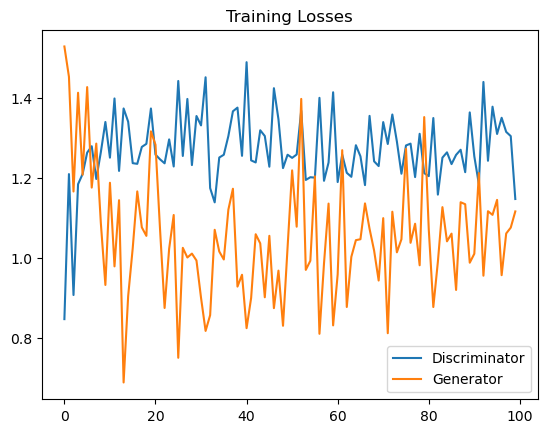

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

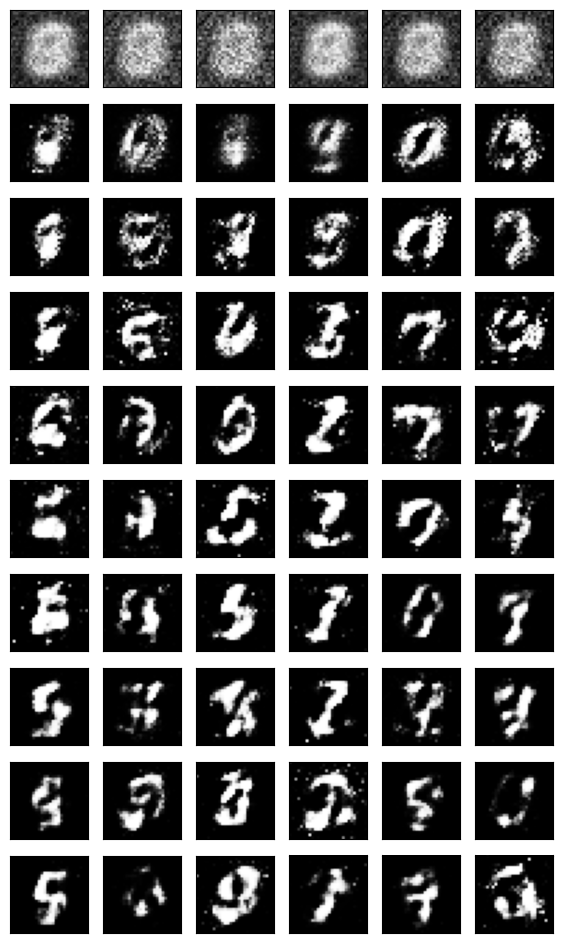

In [17]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

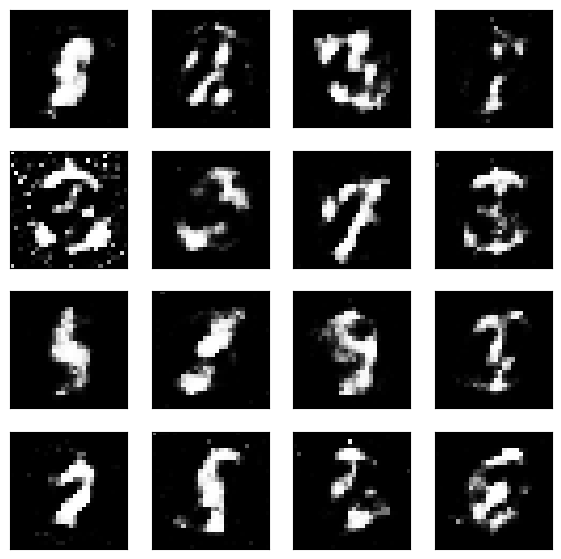

In [19]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

if train_on_gpu:
    G.cpu()
G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])